In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%%capture
!pip install html4vision flask-ngrok tensorboard torchinfo

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Enhanced Residual Networks for Context-based Image Outpainting/densenet/')

PyTorch version:  1.8.1+cu101
Torchvision version:  0.9.1+cu101
train: 812 val: 182 test: 272
device: cuda:0
Batch 1/203  loss_pxl 0.2265  loss_adv 1.3579  loss_D 0.8521
Batch 2/203  loss_pxl 0.2217  loss_adv 11.5217  loss_D 10.1036
Batch 4/203  loss_pxl 0.2289  loss_adv 1.3097  loss_D 1.0556
Batch 8/203  loss_pxl 0.2190  loss_adv 0.6467  loss_D 0.1995
Batch 16/203  loss_pxl 0.2056  loss_adv 0.3752  loss_D 0.1947
Batch 32/203  loss_pxl 0.1850  loss_adv 0.7087  loss_D 0.0678
Batch 64/203  loss_pxl 0.1897  loss_adv 0.5451  loss_D 0.0674
Batch 128/203  loss_pxl 0.1558  loss_adv 0.9403  loss_D 0.0167
Generated image table at: /content/drive/MyDrive/Enhanced Residual Networks for Context-based Image Outpainting/densenet/outpaint_html/0/index.html
Epoch 1/150  train  loss_pxl 0.1593  loss_adv 0.9267  loss_D 0.1678
Epoch 1/150  val  loss_pxl 0.1234  loss_adv 1.1530  loss_D 0.0503

Batch 1/203  loss_pxl 0.1554  loss_adv 1.1656  loss_D 0.0211
Batch 2/203  loss_pxl 0.1203  loss_adv 1.0459  loss_

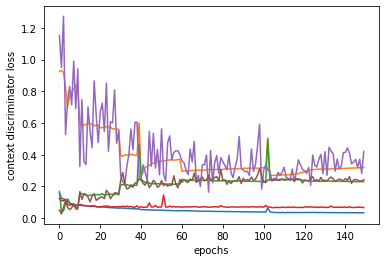

In [4]:
import pickle
import torch
import torchvision
from torch import nn, optim
import matplotlib.pyplot as plt
from torchinfo import summary

import outpainting
import multiple_res_model
import residual_model

'''
Edit the paths here and run to train the GAN.
Uses GPU:0 with CUDA (feel free to switch to CPU or use DataParallel).
'''


print("PyTorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

# Define paths
model_save_path = '/content/drive/MyDrive/Enhanced Residual Networks for Context-based Image Outpainting/densenet/outpaint_models'
html_save_path = '/content/drive/MyDrive/Enhanced Residual Networks for Context-based Image Outpainting/densenet/outpaint_html'
train_dir = '/content/drive/MyDrive/Image Outpainting and Harmonization using GANs - PyTorch Implementation/landscapes_train_test_val_split/train'
val_dir = '/content/drive/MyDrive/Image Outpainting and Harmonization using GANs - PyTorch Implementation/landscapes_train_test_val_split/val'
test_dir = '/content/drive/MyDrive/Image Outpainting and Harmonization using GANs - PyTorch Implementation/landscapes_train_test_val_split/test'

# Define datasets & transforms
my_tf = torchvision.transforms.Compose([
        torchvision.transforms.Resize(outpainting.output_size),
        torchvision.transforms.CenterCrop(outpainting.output_size),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()])
batch_size = 4
train_data = outpainting.CEImageDataset(train_dir, my_tf, outpainting.output_size, outpainting.input_size, outpaint=True)
val_data = outpainting.CEImageDataset(val_dir, my_tf, outpainting.output_size, outpainting.input_size, outpaint=True)
test_data = outpainting.CEImageDataset(test_dir, my_tf, outpainting.output_size, outpainting.input_size, outpaint=True)
train_loader = outpainting.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = outpainting.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = outpainting.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
print('train:', len(train_data), 'val:', len(val_data), 'test:', len(test_data))

# Define model & device
device = torch.device('cuda:0')
G_net = multiple_res_model.CompletionNetwork()
# print(summary(G_net))
# print(G_net.eval())
CD_net = outpainting.ContextDiscriminator((3, outpainting.output_size, outpainting.output_size), (3, outpainting.output_size, outpainting.output_size), arc='places2')
# print(summary(CD_net))
# print(CD_net.eval())
# G_net.load_state_dict(torch.load("/content/drive/MyDrive/Enhanced Residual Networks for Context-based Image Outpainting/residual/G_9.pt"))
# CD_net.load_state_dict(torch.load("/content/drive/MyDrive/Enhanced Residual Networks for Context-based Image Outpainting/residual/D_9.pt"))
G_net.apply(outpainting.weights_init_normal)
CD_net.apply(outpainting.weights_init_normal)
G_net.to(device)
CD_net.to(device)
print('device:', device)

# Start training
data_loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}  # NOTE: test is evidently not used by the train method
n_epochs = 150
adv_weight = [0.001, 0.005, 0.015, 0.040]  # corresponds to epochs 1-10, 10-30, 30-60, 60-onwards
hist_loss = outpainting.train(G_net, CD_net, device,
                              criterion_pxl=nn.L1Loss().to(device),
                              criterion_D=nn.MSELoss().to(device),
                              optimizer_G=optim.Adam(G_net.parameters(), lr=3e-4, betas=(0.5, 0.999)),
                              optimizer_D=optim.Adam(CD_net.parameters(), lr=3e-4, betas=(0.5, 0.999)),
                              data_loaders=data_loaders,
                              model_save_path=model_save_path,
                              html_save_path=html_save_path,
                              n_epochs=n_epochs,
                              adv_weight=adv_weight)

# Save loss history and final generator
pickle.dump(hist_loss, open('/content/drive/MyDrive/Enhanced Residual Networks for Context-based Image Outpainting/densenet/hist_loss.p', 'wb'))

plt.plot(hist_loss['train_pxl'])
plt.xlabel('epochs')
plt.ylabel('L1 loss')
plt.savefig('train_pxl.png')

plt.plot(hist_loss['train_adv'])
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.savefig('train_adv.png')

plt.plot(hist_loss['train_D'])
plt.xlabel('epochs')
plt.ylabel('context discriminator loss')
plt.savefig('train_D.png')

plt.plot(hist_loss['val_pxl'])
plt.xlabel('epochs')
plt.ylabel('L1 loss')
plt.savefig('val_pxl.png')

plt.plot(hist_loss['val_adv'])
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.savefig('val_adv.png')

plt.plot(hist_loss['val_D'])
plt.xlabel('epochs')
plt.ylabel('context discriminator loss')
plt.savefig('val_D.png')

torch.save(G_net.state_dict(), '/content/drive/MyDrive/Enhanced Residual Networks for Context-based Image Outpainting/densenet/generator_final.pt')


In [4]:
import sys
from .outpainting import *

print("PyTorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

src_file = sys.argv[1]
dst_file = sys.argv[2]
gen_model = load_model('generator_final.pt')
print('Source file: ' + src_file + '...')
input_img = plt.imread(src_file)[:, :, :3]
output_img, blended_img = perform_outpaint(gen_model, input_img)
plt.imsave(dst_file, blended_img)
print('Destination file: ' + dst_file + ' written')